# Tutorial: line extraction or seam carving

### All imports

In [1]:
import os

import numpy as np
import scipy

import point_group as gpoints

import skimage.io as skio
import skimage.draw as skdr
import skimage.feature as skf
import skimage.transform as sktr
from skimage import img_as_uint, img_as_int
from matplotlib import pyplot as plt
from proximity_segmentation import calculate_energy, ProximitySegmentation
import warnings
warnings.simplefilter("ignore")

%matplotlib inline

### Constants

In [2]:
src_folder = "input"

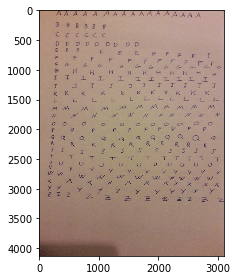

In [3]:
gray_image = skio.imread(os.path.join("input", "characters_sheet.jpg"), as_gray=True)
gray_image = sktr.rotate(gray_image, -90., resize=True)
skio.imshow(gray_image)
skio.show()
#plt.show()

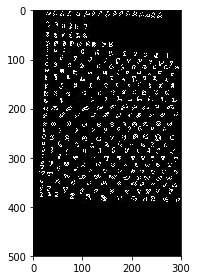

In [4]:
image_canny = skio.imread(os.path.join(src_folder, "canny.jpg"))
image_canny = sktr.rotate(image_canny, -90., resize=True)
skio.imshow(image_canny)
skio.show()

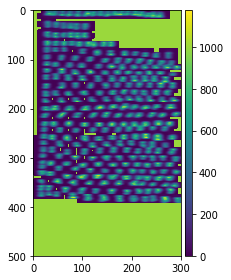

In [5]:
def calculate_energy(image):
    # size = 11
    energy = np.zeros(image.shape)
    size_max = 25
    for size in range(3, size_max, 4):
        kernel = np.zeros((size, size))
        kernel[int(size/2)-2:int(size/2)+2, :] = 1
        energy += (size_max-size)*scipy.ndimage.filters.convolve(image, kernel)
    energy = 1000*(energy == np.zeros(image.shape)) + energy
    return energy

energy = calculate_energy(image_canny)
skio.imshow(energy)
skio.show()

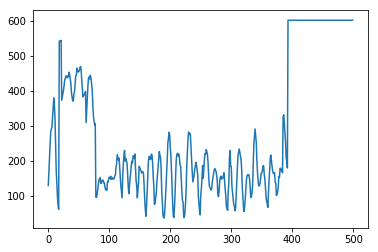

In [6]:
a = np.sum(energy, axis=1)/500
plt.plot(a)

There are 89 n_lines.


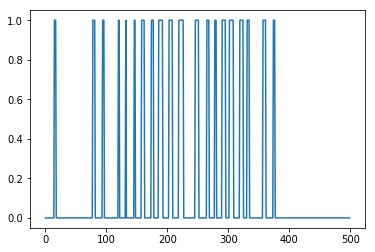

In [7]:
threshold = 125
under_threshold = a < np.ones(a.shape)*threshold
n_lines = np.sum(under_threshold)
plt.plot(under_threshold)
print(f"There are {n_lines} n_lines.")

In [8]:
print("Number of local minima.")
np.sum(np.r_[True, a[1:] < a[:-1]] & np.r_[a[:-1] < a[1:], True])


Number of local minima.


59

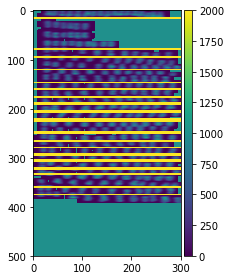

In [9]:
i = 0
for under in under_threshold:
    if under:
        rr, cc = skdr.draw.line(i, 0, i, energy.shape[1]-1)
        energy[rr, cc] = 2000
    i += 1
skio.imshow(energy)
skio.show()

### Run-length Smearing

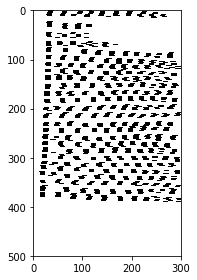

In [10]:
def fill_lines(image, threshold, gap_tolerance):
    image = image < np.ones(image.shape)*threshold
    new_image = np.zeros(image.shape)
    lines = []
    for line in range(image.shape[0]):
        color = image[line, 0]
        index = 0
        lines.append([[color, 1],])
        new_image[line, 0] = color
        for column in range(1, image.shape[1]):
            if image[line, column] == color:
                lines[line][index][1] += 1
                new_image[line, column] = color
            else:
                if lines[line][index][1] > gap_tolerance:
                    color = image[line, column]
                    #print(line, index)
                    lines[line].append([color, 1])
                    index += 1
                    new_image[line, column] = color
                else:
                    lines[line][index][1] += 1
                    new_image[line, column] = color
                    
                
    return new_image
im_lines_filled = fill_lines(image_canny, 0.5, 10)
skio.imshow(im_lines_filled)
skio.show()

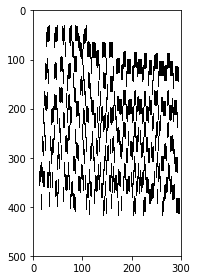

In [11]:
def fill_colums(image, threshold, gap_tolerance):
    image = image < np.ones(image.shape)*threshold
    new_image = np.zeros(image.shape)
    columns = []
    for column in range(image.shape[1]):
        color = image[0, column]
        index = 0
        columns.append([[color, 1],])
        new_image[0, column] = color
        for line in range(1, image.shape[0]):
            if image[line, column] == color:
                columns[column][index][1] += 1
                new_image[line, column] = color
            else:
                if columns[column][index][1] > gap_tolerance:
                    color = image[line, column]
                    #print(line, index)
                    columns[column].append([color, 1])
                    index += 1
                    new_image[line, column] = color
                else:
                    columns[column][index][1] += 1
                    new_image[line, column] = color
                    
                
    return new_image
im_columns_filled = fill_colums(image_canny, 0.5, 30)
skio.imshow(im_columns_filled)
skio.show()

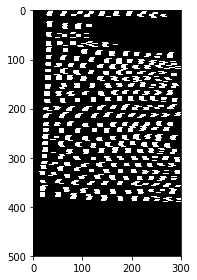

In [12]:
skio.imshow(im_columns_filled % im_lines_filled)
skio.show()

### X-Y Cut

### Docstrum

### Whitespace Analysis

### Voronoi

## Characters extraction

1) Retrieval of gray-scaled image

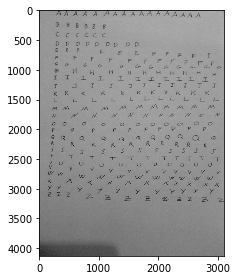

In [13]:
src_folder = "input"
src_picture = "characters_sheet.jpg"
dst_folder = "letters"

gray_image = skio.imread(os.path.join(src_folder, src_picture), as_grey=True)
gray_image = sktr.rotate(gray_image, -90., resize=True)
skio.imshow(gray_image)
skio.show()

2) Resizing

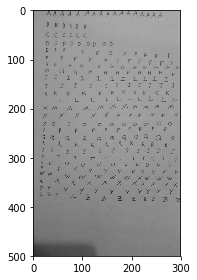

In [14]:
tt = 500
uu = 300
resized_image = sktr.resize(gray_image, (tt, uu))
skio.imshow(resized_image)
skio.show()

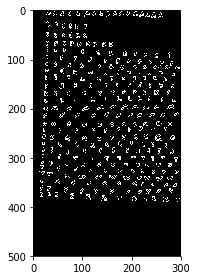

In [15]:
image_canny = np.uint8(skf.canny(resized_image))*255
skio.imshow(image_canny)
skio.show()

3) character segmentation

In [16]:
pc = gpoints.PointGroup()
for i in range(uu):
    for j in range(tt):
        if image_canny[j, i] == 255:
            pc.append_point(gpoints.Point(i, j))
print("Points added")
spp = ProximitySegmentation(pc, 3)
spp.segment()


Points added


In [17]:
print("Number of characters detected:", len(spp.tags))

Number of characters detected: 279


4) character extraction

S


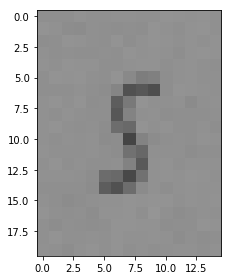

F


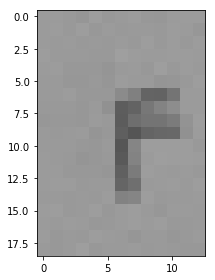

I


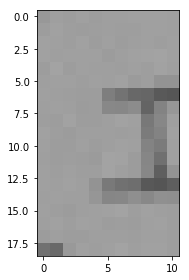

In [23]:
hh = 0
if not os.path.exists(dst_folder):
    os.mkdir(dst_folder)
l_mini_images = []
for gp in spp.tags:
    if gp.calculate_min_y() - 5 >= 0 and gp.calculate_max_y()+5 < tt and \
            gp.calculate_min_x()-5 >= 0 and gp.calculate_max_x()+5 < uu:
        mini_im = resized_image[gp.calculate_min_y() - 5:gp.calculate_max_y() + 5,
            gp.calculate_min_x() - 5:gp.calculate_max_x() + 5]
        l_mini_images.append(mini_im)
        hh += 1
print("S")
skio.imshow(l_mini_images[30])
skio.show()
print("F")
skio.imshow(l_mini_images[50])
skio.show()
print("I")
skio.imshow(l_mini_images[200])
skio.show()

## Sources

[TEXT LINE EXTRACTION USING SEAM CARVING](https://etd.ohiolink.edu/!etd.send_file?accession=akron1428077337&disposition=inline) by Christopher Stoll



**Author**: Clément Besnier, [@clemsciences](https://twitter.com/clemsciences) and  [my personal website](https://clementbesnier.pythonanywhere.com)
    